## 1 Autoencoder

In [33]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, LSTM, Embedding,Conv1D, MaxPool1D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
import cv2
import pandas as pd
import csv
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

In [3]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [4]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [5]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 51s 849us/step - loss: 0.2032 - val_loss: 0.1590
Epoch 2/50
60000/60000 [==============================] - 51s 849us/step - loss: 0.1457 - val_loss: 0.1345
Epoch 3/50
60000/60000 [==============================] - 52s 865us/step - loss: 0.1328 - val_loss: 0.1242
Epoch 4/50
60000/60000 [==============================] - 531s 9ms/step - loss: 0.1256 - val_loss: 0.1212
Epoch 5/50
60000/60000 [==============================] - 54s 902us/step - loss: 0.1208 - val_loss: 0.1196
Epoch 6/50
60000/60000 [==============================] - 54s 896us/step - loss: 0.1172 - val_loss: 0.1145
Epoch 7/50
60000/60000 [==============================] - 54s 895us/step - loss: 0.1143 - val_loss: 0.1142
Epoch 8/50
60000/60000 [==============================] - 54s 900us/step - loss: 0.1118 - val_loss: 0.1092
Epoch 9/50
60000/60000 [==============================] - 53s 879us/step - loss: 0.1104 - val_l

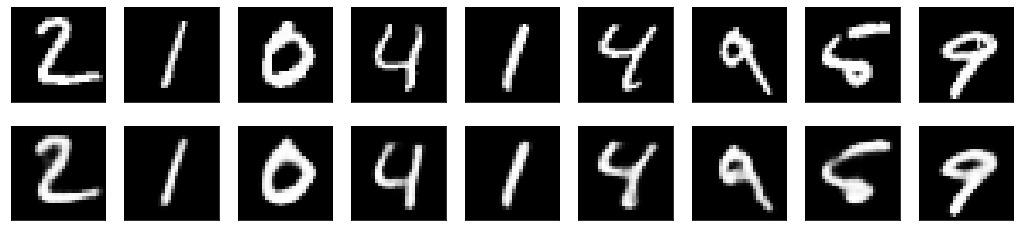

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2 Image Classification

### 2.1 Deep CNN

In [9]:
num_classes = 10
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(32, activation = 'relu')(x)
output = Dense(num_classes, activation = 'softmax')(x)

In [10]:
cnn = Model(input_img, output)
cnn.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
cnn.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          validation_data=(x_test, y_test))
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 13s 210us/step - loss: 0.4779 - acc: 0.8438 - val_loss: 0.1371 - val_acc: 0.9566
Epoch 2/15
60000/60000 [==============================] - 13s 214us/step - loss: 0.1369 - acc: 0.9560 - val_loss: 0.1295 - val_acc: 0.9592
Epoch 3/15
60000/60000 [==============================] - 13s 215us/step - loss: 0.1066 - acc: 0.9669 - val_loss: 0.0843 - val_acc: 0.9719
Epoch 4/15
60000/60000 [==============================] - 16s 266us/step - loss: 0.0909 - acc: 0.9708 - val_loss: 0.0954 - val_acc: 0.9693
Epoch 5/15
60000/60000 [==============================] - 18s 304us/step - loss: 0.0819 - acc: 0.9742 - val_loss: 0.0690 - val_acc: 0.9772
Epoch 6/15
60000/60000 [==============================] - 19s 310us/step - loss: 0.0746 - acc: 0.9763 - val_loss: 0.0679 - val_acc: 0.9778
Epoch 7/15
60000/60000 [==============================] - 19s 313us/step - loss: 0.0702 - acc: 0.9782 - val_loss: 0.

## 2.2 Transfer Learning

In [13]:
num_classes = 10
input_img = Input(shape=(32, 32, 3))

In [14]:
vgg_model = VGG16(weights='imagenet', include_top=False)
for layer in vgg_model.layers:
    layer.trainable = False
vgg_output = vgg_model(input_img)
x = Flatten()(vgg_output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

tl_model = Model(inputs = input_img, outputs = output)
tl_model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_train]
x_train = np.array(x_train).astype('float32')

x_test = [cv2.cvtColor(cv2.resize(i, (32,32)), cv2.COLOR_GRAY2BGR) for i in x_test]
x_test = np.array(x_test).astype('float32')

x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [16]:
tl_model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(x_test, y_test))
score = tl_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3758s 63ms/step - loss: 0.5141 - acc: 0.8540 - val_loss: 0.2360 - val_acc: 0.9297
Epoch 2/5
60000/60000 [==============================] - 298s 5ms/step - loss: 0.2081 - acc: 0.9371 - val_loss: 0.1871 - val_acc: 0.9417
Epoch 3/5
60000/60000 [==============================] - 226s 4ms/step - loss: 0.1635 - acc: 0.9498 - val_loss: 0.1519 - val_acc: 0.9519
Epoch 4/5
60000/60000 [==============================] - 228s 4ms/step - loss: 0.1418 - acc: 0.9562 - val_loss: 0.1255 - val_acc: 0.9606
Epoch 5/5
60000/60000 [==============================] - 229s 4ms/step - loss: 0.1275 - acc: 0.9596 - val_loss: 0.1209 - val_acc: 0.9613
Test loss: 0.12091823821961879
Test accuracy: 0.9613


## 3 Text Classification

### 3.1 RNN

In [17]:

with open('processed.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, dialect='excel')
    with open('twitter-data/tweets_with_labels.txt', 'r') as txtfile:
        for line in txtfile:
            line_list = line.strip('\n').split('\t')
            writer.writerow(line_list[0:17])
df = pd.read_csv('processed.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### 3.1.1 using softmax

In [18]:
def change(i):
    try:
        float(i)
        return float(i)
    except ValueError:
        return 0
text = []
labels = []
signs = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = set(stopwords.words('english'))
maxl = 0
for i in range(len(df)):
    label = []
    label.append(change(df.k1[i]))
    label.append(change(df.k2[i]))
    label.append(change(df.k3[i]))
    label.append(change(df.k4[i]))
    label.append(change(df.k5[i]))
    label.append(change(df.k6[i]))
    label.append(change(df.k7[i]))
    label.append(change(df.k8[i]))
    label.append(change(df.k9[i]))
    label.append(change(df.k10[i]))
    label.append(change(df.k11[i]))
    label.append(change(df.k12[i]))
    label.append(change(df.k13[i]))
    label.append(change(df.k14[i]))
    label.append(change(df.k15[i]))
    
    labels.append(label.index(max(label)))
    t = df.tweet[i]
    t = t.lower()
    t = signs.sub(' ', t)
    t = ' '.join(word for word in t.split() if word not in STOPWORDS)
    text.append(t)
    if len(t.split()) > maxl:
        maxl = len(t.split())

In [19]:
X_train,X_test,Y_train,Y_test = train_test_split(text, labels, test_size=0.25)

max_words = 50000
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=maxl)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=maxl)
Y_train = keras.utils.to_categorical(Y_train, 15)
Y_test = keras.utils.to_categorical(Y_test, 15)

In [20]:
input = Input(shape = [maxl])
x = Embedding(max_words,50,input_length = maxl)(input)
x = LSTM(128)(x)
x = Dense(256, activation ='relu')(x)
output = Dense(15,  activation = 'softmax')(x)
model_rnn_softmax = Model(inputs=input,outputs=output)
model_rnn_softmax.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model_rnn_softmax.fit(train_sequences_matrix,
           Y_train,
           batch_size=128,
           epochs=20, 
           validation_data=(test_sequences_matrix, Y_test))

Train on 58459 samples, validate on 19487 samples
Epoch 1/20
58459/58459 [==============================] - 25s 433us/step - loss: 1.2189 - acc: 0.6317 - val_loss: 0.7158 - val_acc: 0.8029
Epoch 2/20
58459/58459 [==============================] - 25s 420us/step - loss: 0.6058 - acc: 0.8265 - val_loss: 0.6025 - val_acc: 0.8253
Epoch 3/20
58459/58459 [==============================] - 24s 415us/step - loss: 0.5122 - acc: 0.8464 - val_loss: 0.5947 - val_acc: 0.8282
Epoch 4/20
58459/58459 [==============================] - 25s 421us/step - loss: 0.4589 - acc: 0.8590 - val_loss: 0.5826 - val_acc: 0.8301
Epoch 5/20
58459/58459 [==============================] - 24s 408us/step - loss: 0.4174 - acc: 0.8689 - val_loss: 0.5977 - val_acc: 0.8275
Epoch 6/20
58459/58459 [==============================] - 24s 404us/step - loss: 0.3827 - acc: 0.8794 - val_loss: 0.6074 - val_acc: 0.8292
Epoch 7/20
58459/58459 [==============================] - 24s 404us/step - loss: 0.3528 - acc: 0.8878 - val_loss: 0.

In [21]:
score = model_rnn_softmax.evaluate(test_sequences_matrix, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.100634970124569
Test accuracy: 0.7588135680319402


#### 3.1.2 using sigmoid

In [22]:
def new_change(i):
    try:
        float(i)
        if float(i) > 0:
            return 1
        else:
            return 0
    except ValueError:
        return 0
text = []
labels = []
signs = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = set(stopwords.words('english'))
maxl = 0
for i in range(len(df)):
    label = []
    label.append(new_change(df.k1[i]))
    label.append(new_change(df.k2[i]))
    label.append(new_change(df.k3[i]))
    label.append(new_change(df.k4[i]))
    label.append(new_change(df.k5[i]))
    label.append(new_change(df.k6[i]))
    label.append(new_change(df.k7[i]))
    label.append(new_change(df.k8[i]))
    label.append(new_change(df.k9[i]))
    label.append(new_change(df.k10[i]))
    label.append(new_change(df.k11[i]))
    label.append(new_change(df.k12[i]))
    label.append(new_change(df.k13[i]))
    label.append(new_change(df.k14[i]))
    label.append(new_change(df.k15[i]))
    labels.append(label)
    t = df.tweet[i]
    t = t.lower()
    t = signs.sub(' ', t)
    t = ' '.join(word for word in t.split() if word not in STOPWORDS)
    text.append(t)
    if len(t.split()) > maxl:
        maxl = len(t.split())

In [23]:
X_train,X_test,Y_train,Y_test = train_test_split(text, labels, test_size=0.25)

max_words = 50000
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=maxl)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=maxl)

In [24]:
input = Input(shape = [maxl])
x = Embedding(max_words,50,input_length = maxl)(input)
x = LSTM(128)(x)
x = Dense(256, activation ='relu')(x)
output = Dense(15,  activation = 'sigmoid')(x)
model_rnn_sigmoid = Model(inputs=input,outputs=output)
model_rnn_sigmoid.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model_rnn_sigmoid.fit(train_sequences_matrix,
           Y_train,
           batch_size=128,
           epochs=20, 
           validation_data=(test_sequences_matrix, Y_test))


Train on 58459 samples, validate on 19487 samples
Epoch 1/20
58459/58459 [==============================] - 25s 425us/step - loss: 0.2545 - acc: 0.9017 - val_loss: 0.1842 - val_acc: 0.9318
Epoch 2/20
58459/58459 [==============================] - 24s 410us/step - loss: 0.1604 - acc: 0.9422 - val_loss: 0.1515 - val_acc: 0.9450
Epoch 3/20
58459/58459 [==============================] - 24s 413us/step - loss: 0.1409 - acc: 0.9486 - val_loss: 0.1443 - val_acc: 0.9479
Epoch 4/20
58459/58459 [==============================] - 25s 422us/step - loss: 0.1310 - acc: 0.9523 - val_loss: 0.1403 - val_acc: 0.9500
Epoch 5/20
58459/58459 [==============================] - 26s 443us/step - loss: 0.1243 - acc: 0.9545 - val_loss: 0.1411 - val_acc: 0.9492
Epoch 6/20
58459/58459 [==============================] - 26s 437us/step - loss: 0.1190 - acc: 0.9564 - val_loss: 0.1400 - val_acc: 0.9500
Epoch 7/20
58459/58459 [==============================] - 24s 408us/step - loss: 0.1139 - acc: 0.9581 - val_loss: 0.

In [40]:
score = model_rnn_sigmoid.evaluate(test_sequences_matrix, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y_rnn = model_rnn_sigmoid.predict(test_sequences_matrix)
fpr_rnn, tpr_rnn, rnn_ = roc_curve(Y_test.ravel(), pred_y_rnn.ravel())
auc_rnn = auc(fpr_rnn, tpr_rnn)

Test loss: 0.21276537773576984
Test accuracy: 0.9399155230025914


### 3.2 CNN
#### because in RNN the sigmoid performs better, so I just use sigmoid here

In [41]:
x = Embedding(max_words,50,input_length = maxl)(input)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
x = MaxPool1D(2, padding='same')(x)
x = Conv1D(4, 3, activation='relu', padding='same')(x)
x = MaxPool1D(2, padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation ='relu')(x)
output = Dense(15,  activation = 'sigmoid')(x)
model_cnn_sigmoid = Model(inputs=input,outputs=output)
model_cnn_sigmoid.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
model_cnn_sigmoid.fit(train_sequences_matrix,
           Y_train,
           batch_size=128,
           epochs=20, 
           validation_data=(test_sequences_matrix, Y_test))

Train on 58459 samples, validate on 19487 samples
Epoch 1/20
58459/58459 [==============================] - 12s 198us/step - loss: 0.2758 - acc: 0.8979 - val_loss: 0.2222 - val_acc: 0.9155
Epoch 2/20
58459/58459 [==============================] - 11s 187us/step - loss: 0.1936 - acc: 0.9299 - val_loss: 0.1823 - val_acc: 0.9356
Epoch 3/20
58459/58459 [==============================] - 11s 189us/step - loss: 0.1694 - acc: 0.9395 - val_loss: 0.1720 - val_acc: 0.9383
Epoch 4/20
58459/58459 [==============================] - 11s 189us/step - loss: 0.1584 - acc: 0.9430 - val_loss: 0.1690 - val_acc: 0.9395
Epoch 5/20
58459/58459 [==============================] - 11s 188us/step - loss: 0.1497 - acc: 0.9459 - val_loss: 0.1691 - val_acc: 0.9388
Epoch 6/20
58459/58459 [==============================] - 11s 188us/step - loss: 0.1422 - acc: 0.9484 - val_loss: 0.1656 - val_acc: 0.9411
Epoch 7/20
58459/58459 [==============================] - 11s 190us/step - loss: 0.1355 - acc: 0.9511 - val_loss: 0.

In [42]:
score = model_cnn_sigmoid.evaluate(test_sequences_matrix, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y_cnn = model_cnn_sigmoid.predict(test_sequences_matrix).ravel()
fpr_cnn, tpr_cnn, cnn_ = roc_curve(Y_test.ravel(), pred_y_cnn.ravel())
auc_cnn = auc(fpr_cnn, tpr_cnn)

Test loss: 0.21615662076569034
Test accuracy: 0.9309659607415203


### 3.3

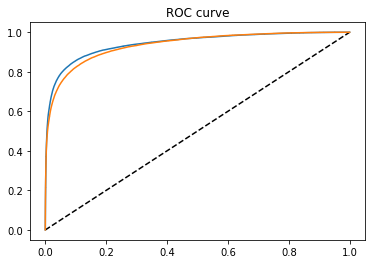

Rnn Accuracy 0.9425861787478338
Cnn Accuracy 0.9349439428923351


In [43]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn)
plt.plot(fpr_cnn, tpr_cnn)
plt.title('ROC curve')
plt.show()

print("Rnn Accuracy", auc_rnn)
print("Cnn Accuracy", auc_cnn)